# Intro
Here I take a look at the way I spend money and draw some insights from it. It could help me handle my finances in a more meaningful way.<br>

### Data

The data is taken from my personal expenses accounting. I've been manually adding values to a Google Sheets table after every purchase from July 30 to September 27, 2022. <br>

It is divided into three types of spending: `meals` (what I bought for lunches and dinners), `other` (some other necessary spending), and `extra` (all non-essential stuff such as coffee or desserts). 
After every week in the Date column, there are `Spent/Avg` and `Rest/Error` rows which show the sum and average of money spent by week and how much money is rest from what's been allocated for a time period + how much money is missing from the calculations.<br>

I deliberately kept this table in a way that's more convenient for the Excel format, not for Python (the only assumption is that I didn't start addition with the equal sign). Because of that, it requires a lot of pre-processing before it could be suited for data analysis with pandas.


### Steps


In this project I will:
1. Clean the data.
1. Summarize my spending for two months.
2. Question: Which items did I spend the most on?
3. Question: How do the three categories (Meals, Other, Extra) differ?
4. Break down the Extra category and compare it to the other two.

# Explore Data

Import libraries and load the data sets

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
detailed = pd.read_excel('spending.xlsx', sheet_name='Spent (Apr 1 - Sep 23) +', header=0, skiprows=lambda x: x in range(1, 139))

In [6]:
detailed.head()

,Date,Out,-,+,Main Meals,Est. Price,Total Price,Other,Est. Price.1,Total Price.1,Extra,Est. Price.2,Total Price.2
0,2022-07-30 00:00:00,30.0,NaN,NaN,"Bread, Milk, Paper, Coffee, Butter, Chocolate",1100.0,30+60+250+630+170+138,Napkins,30.0,30,Junk food,0.0,300
1,2022-07-31 00:00:00,245.0,NaN,NaN,"Yogurt, Bread",200.0,98+76,Toothpaste,250.0,245,-,0.0,0
2,2022-08-01 00:00:00,NaN,NaN,NaN,"Pasta, tomatoes, mushrooms, spinach, cheese",635.0,80+100+96+155+204,"Eggs, Crispbread, Bread",352.0,145+76+76+16,Coffee with cherry pies,1000.0,890
3,2022-08-02 00:00:00,NaN,NaN,NaN,"Beans, quinoa",150.0,40+90,"Syrnyky, Milk, Tea, Apples",300.0,82 + 80 + 45 + 43,-,0.0,0
4,2022-08-03 00:00:00,NaN,7.0,NaN,Pizza,600.0,295,"Train tickets, Fare",2000.0,1748+680,-,0.0,0


In [7]:
detailed.shape

(78, 13)

In [8]:
detailed.dtypes

Date              object
Out              float64
-                float64
+                float64
Main Meals        object
Est. Price       float64
Total Price       object
Other             object
Est. Price.1     float64
Total Price.1     object
Extra             object
Est. Price.2     float64
Total Price.2     object
dtype: object

In [9]:
detailed['Date'].iloc[0], detailed['Date'].iloc[-3]

(datetime.datetime(2022, 7, 30, 0, 0), datetime.datetime(2022, 9, 27, 0, 0))

DataFrame spans the period from July 30 to September 27, 2022. The data types are mostly correct, but because the `Date` column contains datetime and string values it is read as the 'object' dtype. <br>
About half of the columns make sense within the analysis in Excel, but for the purposes of this project, they need to be removed.

# Process Data

#### Clean the DataFrame

In [15]:
detailed.columns

Index(['Date', 'Out', '-', '+', 'Main Meals', 'Est. Price', 'Total Price',
       'Other', 'Est. Price.1', 'Total Price.1', 'Extra', 'Est. Price.2',
       'Total Price.2'],
      dtype='object')

In [16]:
# Remove unnecessary columns
detailed = detailed.drop(columns=['Out', '-', '+', 'Est. Price', 'Est. Price.1', 'Est. Price.2'])

In [17]:
# Drop weekly aggregates
not_dates = detailed.loc[(detailed['Date'] == 'Spent / Avg') | (detailed['Date'] == 'Rest / Error')]
detailed = detailed.drop(index=not_dates.index)

#### Reshape the DataFrame
Involves a few steps:
1. Find mismatches in the price and items columns (when there are more / fewer items than prices) and fix that.
2. Break the original table into prices and items tables by unpivoting. Desired output:

3. Split each column by its delimiter with the help of multi-indexing and the stack() method to create the desired table after splitting the columns.

4. Merge new tables back.

+ Create a function for step 3 for best performance.

<b>Step 1</b>. After running the total_df_reshape function, provided below, it was found, that the number of rows in the category and price DataFrames are unequal. There are 473 prices and 466 items. A possible reason is there some prices were put into the original Excel table without an item purchased.<br>
To fix that, iterate through the detailed table and count the number of items and prices in each row. If there's a discrepancy, print the index of this row, so we could check a possible left out.

In [18]:
# Function which iterates through each column, counts items / prices and tells if they're unequal
def find_mismatch_ind(col_item, col_price, delimiter_item = ',', delimiter_price = '+'):
    count_items = 1
    count_prices = 1
    
    for i in str(row[col_item]):
        if i == delimiter_item:
            count_items += 1
            
    for p in str(row[col_price]):
        if p == delimiter_price:
            count_prices += 1  
            
    if count_items != count_prices:
        print(f'Row {ind}, {col_item} – {count_items} items and {count_prices} prices!')
        ind_list.append(ind)

In [19]:
# It's possible to iterate through the column list without typing the names of the columns manually.
# But I consider it as unnecessary overcomplication.
ind_list = []
for ind, row in detailed.iterrows():
    find_mismatch_ind('Main Meals', 'Total Price')
    find_mismatch_ind('Other', 'Total Price.1')
    find_mismatch_ind('Extra', 'Total Price.2')

Row 2, Other – 3 items and 4 prices!
Row 6, Other – 4 items and 5 prices!
Row 6, Extra – 4 items and 1 prices!
Row 13, Other – 3 items and 4 prices!
Row 22, Extra – 3 items and 5 prices!
Row 49, Main Meals – 2 items and 1 prices!
Row 49, Other – 2 items and 3 prices!
Row 50, Other – 7 items and 8 prices!
Row 56, Main Meals – 1 items and 3 prices!
Row 56, Other – 2 items and 3 prices!
Row 59, Other – 2 items and 3 prices!
Row 59, Extra – 4 items and 5 prices!
Row 68, Other – 3 items and 2 prices!


In [20]:
detailed.loc[50]

Date                                           2022-09-08 00:00:00
Main Meals                      Potato, mussels, green bean, bread
Total Price                                          94+359+105+43
Other            Napkins, fruit, oranges, pads, choc, butter, b...
Total Price.1                         140+96+119+140+180+80+150+56
Extra                                                 Coffee, cake
Total Price.2                                              280+210
Name: 50, dtype: object

In [21]:
# Take a closer look at these rows
detailed.loc[ind_list]

,Date,Main Meals,Total Price,Other,Total Price.1,Extra,Total Price.2
2,2022-08-01 00:00:00,"Pasta, tomatoes, mushrooms, spinach, cheese",80+100+96+155+204,"Eggs, Crispbread, Bread",145+76+76+16,Coffee with cherry pies,890
6,2022-08-05 00:00:00,"Mash, broccoli, soy meatballs",62+155+274,"Crispbread, Tomatoes, Cucumbers, Pepper",76+80+51+26+8,"Almond, bananas, peaches, yogurt",527
6,2022-08-05 00:00:00,"Mash, broccoli, soy meatballs",62+155+274,"Crispbread, Tomatoes, Cucumbers, Pepper",76+80+51+26+8,"Almond, bananas, peaches, yogurt",527
13,2022-08-10 00:00:00,"Wok, chickpeas",350+134,"Coffee; banana, milk, bread",640+80+73+36,Lichen,250
22,2022-08-17 00:00:00,-,0,"Bananas, butter, eggs, spice, flour, Nutella",65+150+110+31+80+380,"Gum, taxis, beer",30+221+65+287+147
49,2022-09-07 00:00:00,"Cucumbers, cola",260,"Breakfast, coffee; fare",350+440+180,-,0
49,2022-09-07 00:00:00,"Cucumbers, cola",260,"Breakfast, coffee; fare",350+440+180,-,0
50,2022-09-08 00:00:00,"Potato, mussels, green bean, bread",94+359+105+43,"Napkins, fruit, oranges, pads, choc, butter, b...",140+96+119+140+180+80+150+56,"Coffee, cake",280+210
56,2022-09-12 00:00:00,Burrito,210+250+200,"Fare, bread",180+48+160,-,0
56,2022-09-12 00:00:00,Burrito,210+250+200,"Fare, bread",180+48+160,-,0


In [22]:
# Change or delete a row, based on situaition
detailed.loc[2, 'Total Price.1'] = '145+76+76'
detailed.loc[6, 'Total Price.1'] = '76+80+51+26'
detailed.loc[6, 'Total Price.2'] = '209+65+113+140'
detailed.loc[6, 'Total Price.2'] = '209+65+113+140'
detailed.loc[13, 'Other'] = detailed.loc[13, 'Other'].replace(';', ',')
detailed.loc[22, 'Total Price.2'] = '30+573+147'
detailed.loc[49, 'Total Price'] = '90+170'
detailed.loc[49, 'Other'] = detailed.loc[49, 'Other'].replace(';', ',')
detailed.loc[50, 'Total Price.1'] = '140+96+119+140+260+150+56'
detailed.loc[56, 'Total Price'] = '660'
detailed.loc[56, 'Total Price.1'] = '340+48'
detailed.loc[59, 'Other'] = detailed.loc[59, 'Other'].replace(';', ',')
detailed.loc[59, 'Extra'] = detailed.loc[59, 'Extra'].replace(';', ',')
detailed.loc[68, 'Total Price.1'] = '361+130+180'

<b>Step 2</b>. Reshape the table

In [23]:
detailed_cat = pd.melt(frame=detailed, id_vars = 'Date', value_vars=["Main Meals","Other", "Extra"], value_name="Item", var_name="Category")
detailed_price = pd.melt(frame=detailed, id_vars = 'Date', value_vars=["Total Price","Total Price.1", "Total Price.2"], value_name="Price", var_name="Which Price")

<b>Step 3</b>. Split the items and the summed spending.

In [24]:
def total_df_reshape(df, col, delimiter):
# Create new DF with stacked values

    # But first, treat the plus delimeters differently as a value with no plus is skipped without a lambda
    if delimiter == '+':
        s = df[col].apply(lambda x: x.split(delimiter) if delimiter in str(x) else x).apply(pd.Series).stack()
    else:
        s = df[col].str.title().str.split(delimiter).apply(pd.Series).stack()
    s.name = col
    s = pd.DataFrame(s)
    del df[col]

    # Merge two DFs by first index of s
    indices = s.index.get_level_values(0)
    s[detailed_cat.columns[0:2]] = detailed_cat.loc[indices].values

    # Rearrange the columns
    s_cols = list(s.columns)
    s = s[s_cols[1:2] + s_cols[0:1] + s_cols[2:3]]
    return s.reset_index(drop=True)

new_detailed_cat = total_df_reshape(detailed_cat, 'Item', ', ')
new_detailed_price = total_df_reshape(detailed_price, 'Price', '+')
# del new_detailed_price['Category']

In [25]:
len(new_detailed_price), len(new_detailed_cat)

(470, 470)

<b>Step 4</b>. Merge the table back.

In [26]:
# pd.merge(new_detailed_price, new_detailed_cat, left_index=True, right_index=True)
detailed_new = new_detailed_cat.join(new_detailed_price, rsuffix='_')
detailed_new = detailed_new.drop(columns=['Date_', 'Category_'])

In [27]:
# Check the date types
detailed_new.dtypes

Date        datetime64[ns]
Item                object
Category            object
Price               object
dtype: object

In [28]:
# Change data types
detailed_new['Price'] = detailed_new['Price'].astype('int')

In [29]:
# The final version of the dataset
detailed_new.head(10)

,Date,Item,Category,Price
0,2022-07-30,Bread,Main Meals,30
1,2022-07-30,Milk,Main Meals,60
2,2022-07-30,Paper,Main Meals,250
3,2022-07-30,Coffee,Main Meals,630
4,2022-07-30,Butter,Main Meals,170
5,2022-07-30,Chocolate,Main Meals,138
6,2022-07-31,Yogurt,Main Meals,98
7,2022-07-31,Bread,Main Meals,76
8,2022-08-01,Pasta,Main Meals,80
9,2022-08-01,Tomatoes,Main Meals,100


# Analyze Data

#### Price statistics

In [30]:
detailed_new.describe()

,Price
count,470.00000
mean,149.13617
std,181.24905
min,0.00000
25%,58.00000
50%,105.00000
75%,170.75000
max,1748.00000


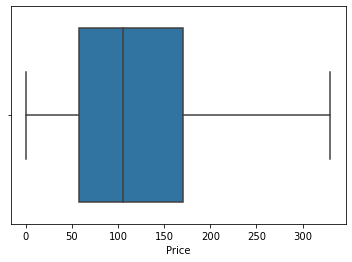

In [31]:
sns.boxplot(data=detailed_new, x='Price', showfliers=False)
plt.show()

#### Item statistics

In [32]:
detailed_new.Item.nunique()

155

In [33]:
items_summed = detailed_new.groupby('Item').agg({'Price': 'sum', 'Item': 'count'})
items_summed = items_summed.rename(columns={'Price': 'Total Price', 'Item': 'Amount'})
items_summed['Average Price'] = round(items_summed['Total Price'] / items_summed['Amount'], 2)
items_summed = items_summed.sort_values(by='Total Price', ascending=False)

# Top-5 items which I spent the most money
items_summed.head()

,Total Price,Amount,Average Price
Item,,,
Coffee,7139,22,324.50
Fare,2800,17,164.71
Cake,2586,14,184.71
Taxi,2407,5,481.40
Cafe,2300,2,1150.00


#### Categories comparison

In [34]:
categories = detailed_new.groupby('Category')['Price'].sum().reset_index()
categories

,Category,Price
0,Extra,16329
1,Main Meals,24590
2,Other,29175


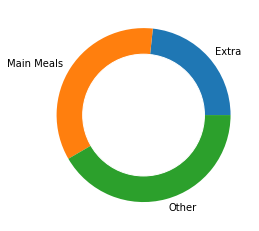

In [35]:
plt.pie(categories['Price'], labels=categories['Category'])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

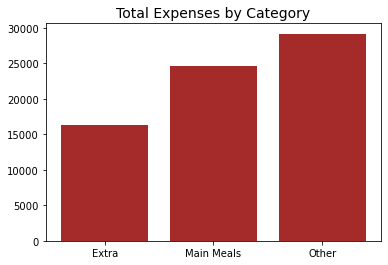

In [36]:
# As we see, all three categories seem not be differ dramatically. Check it with barplot:
# counts_cat = list(categories['index'])
# categories_cat = list(categories['Category'])
plt.bar(categories['Category'], categories['Price'], color='brown')
plt.title('Total Expenses by Category', fontsize=14)
plt.show()

#### Detailed look at the Extra category
This category, despite its name, is quite large. A possible reason is that four out five most expensive items (see the items_summed table above) are from this category. <br> 
Let's take a look at what percentage coffee makes up in Extra.

In [37]:
coffee_sum_detailed = np.sum(detailed_new.loc[detailed_new['Item'].str.contains('Coffee')].Price)
extra_prices = detailed_new.loc[detailed_new['Category'] == 'Extra'].Price
print(coffee_sum_detailed / np.sum(extra_prices) * 100)

49.17018800906363


Coffee takes up almost half of all expenses in the Extra category. <br> Finally, let's check if all the products in it cost more on average.

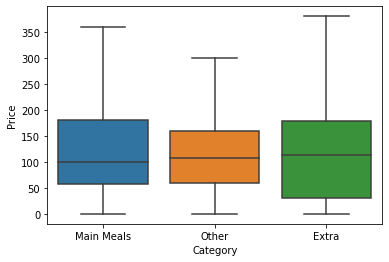

In [38]:
sns.boxplot(data=detailed_new, x='Category', y='Price', showfliers=False)
plt.show()

Since the Price data is not normally distributed (but right-skewed), run the Kruskal-Wallis H-test to check if the medians of all three categories are from the same population 

In [39]:
other_prices = detailed_new.loc[detailed_new['Category'] == 'Other'].Price
meal_prices = detailed_new.loc[detailed_new['Category'] == 'Main Meals'].Price
pval = stats.kruskal(extra_prices, other_prices, meal_prices)[1]
print(pval)

0.7095417875569991


Since the p-value is 0.71, we fail to reject the hypothesis that the Extra category prices were higher than those from two other categories.<br>
Note: the average prices in three categories are 154, 145, and 151.

# Conclusion

### Data processing
- Mismatched columns were detected and fixed.  

- The detailed table was reshaped and split into categories and prices with pd.melt.

- Split the prices and items columns by corresponding delimiters in these two data subsets with df.apply, df.stack and regex. Then they were merged back.

### Key findings
1. The average purchase cost is around 150. But this value is heavily influenced by outliers (e.g. the biggest purchase was 1748). The median is 105, which suggests that most of the spending were much lower than 150.

2. The most common item I bought for the two months of keeping the table was coffee (no surprise, as half of this project was dedicated to this very product). Desserts for coffee take up the third position. Transportation is number two and four (subway/buses and taxis).

3. 'Other' (necessary items excluding food) is the most common category.

4. Coffee makes up 49% of all the spending in the Extra category and this is the most expensive item in the dataset. It explains the big size of this category.<br>
The hypothesis that products from the Extra category are more expensive on average was couldn't be rejected.